In [1]:
!pip install transformers

In [2]:
!pip install torch


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set initial configurations and constants

# 1. Set the inline backend figure format to 'retina' for higher resolution in Jupyter Notebook
%config InlineBackend.figure_format='retina'

# 2. Configure Seaborn styles for visualizations
# - Use white grid style, muted color palette, and adjust font scale for readability
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# 3. Define a custom color palette for Seaborn plots
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# 4. Set default figure size for plots
rcParams['figure.figsize'] = 12, 8

# 5. Set a random seed for reproducibility
# - This ensures consistent results when splitting data and initializing models
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 6. Set the computation device
# - Checks if a GPU is available; if not, defaults to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATASET

In [5]:
df = pd.read_csv('Restaurant reviews.csv')
df.shape

(10000, 8)

In [6]:
df.head()

,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


In [7]:
# Keep only the relevant columns
df = df[['Review', 'Rating']]

In [8]:
# Let's check for missing values
df.isnull().sum()

,0
Review,45
Rating,38


In [9]:
# Convert 'Rating' to numeric, forcing errors to NaN
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')


In [10]:
# Let's check for missing values
df.isnull().sum()

,0
Review,45
Rating,39


In [11]:
df_cleaned = df.dropna()

In [12]:
df_cleaned.shape

(9954, 2)

In [13]:
df_cleaned

,Review,Rating
0,"The ambience was good, food was quite good . h...",5.0
1,Ambience is too good for a pleasant evening. S...,5.0
2,A must try.. great food great ambience. Thnx f...,5.0
3,Soumen das and Arun was a great guy. Only beca...,5.0
4,Food is good.we ordered Kodi drumsticks and ba...,5.0
...,...,...
9995,Madhumathi Mahajan Well to start with nice cou...,3.0
9996,This place has never disappointed us.. The foo...,4.5
9997,"Bad rating is mainly because of ""Chicken Bone ...",1.5
9998,I personally love and prefer Chinese Food. Had...,4.0


In [14]:
# Define sentiment labels based on ratings
df_cleaned['Sentiment'] = df_cleaned['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [15]:
df_cleaned.head()

,Review,Rating,Sentiment
0,"The ambience was good, food was quite good . h...",5.0,1
1,Ambience is too good for a pleasant evening. S...,5.0,1
2,A must try.. great food great ambience. Thnx f...,5.0,1
3,Soumen das and Arun was a great guy. Only beca...,5.0,1
4,Food is good.we ordered Kodi drumsticks and ba...,5.0,1


In [16]:
# Separate the positive and negative reviews
df_positive = df_cleaned[df_cleaned['Sentiment'] == 1]
df_negative = df_cleaned[df_cleaned['Sentiment'] == 0]


In [17]:
len(df_positive)

6315

In [18]:
len(df_negative)

3639

In [19]:
from sklearn.utils import resample
# Upsample the negative samples
df_negative_upsampled = resample(df_negative,
                                 replace=True,        # Sample with replacement
                                 n_samples=6315,      # Match number of positive samples
                                 random_state=42)     # For reproducibility

In [20]:

len(df_negative_upsampled)

6315

In [21]:
# Combine the positive samples with the upsampled negative samples
df_balanced = pd.concat([df_positive, df_negative_upsampled])
# Shuffle the combined dataset to mix positive and negative samples
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [22]:
df_balanced

,Review,Rating,Sentiment
0,We a bunch of friends went for a holiday dinne...,1.0,0
1,We went for lunch buffet. Food taste is averag...,2.0,0
2,Super,5.0,1
3,"I ordered chicken fried rice, there were not t...",2.0,0
4,the dish was extremely oily. the tandoori roti...,2.0,0
...,...,...,...
12625,average,2.0,0
12626,kulcha was more salty,4.0,1
12627,A good place for some Telangana taste! The gri...,3.5,1
12628,More expensive than the other barbecue counter...,5.0,1


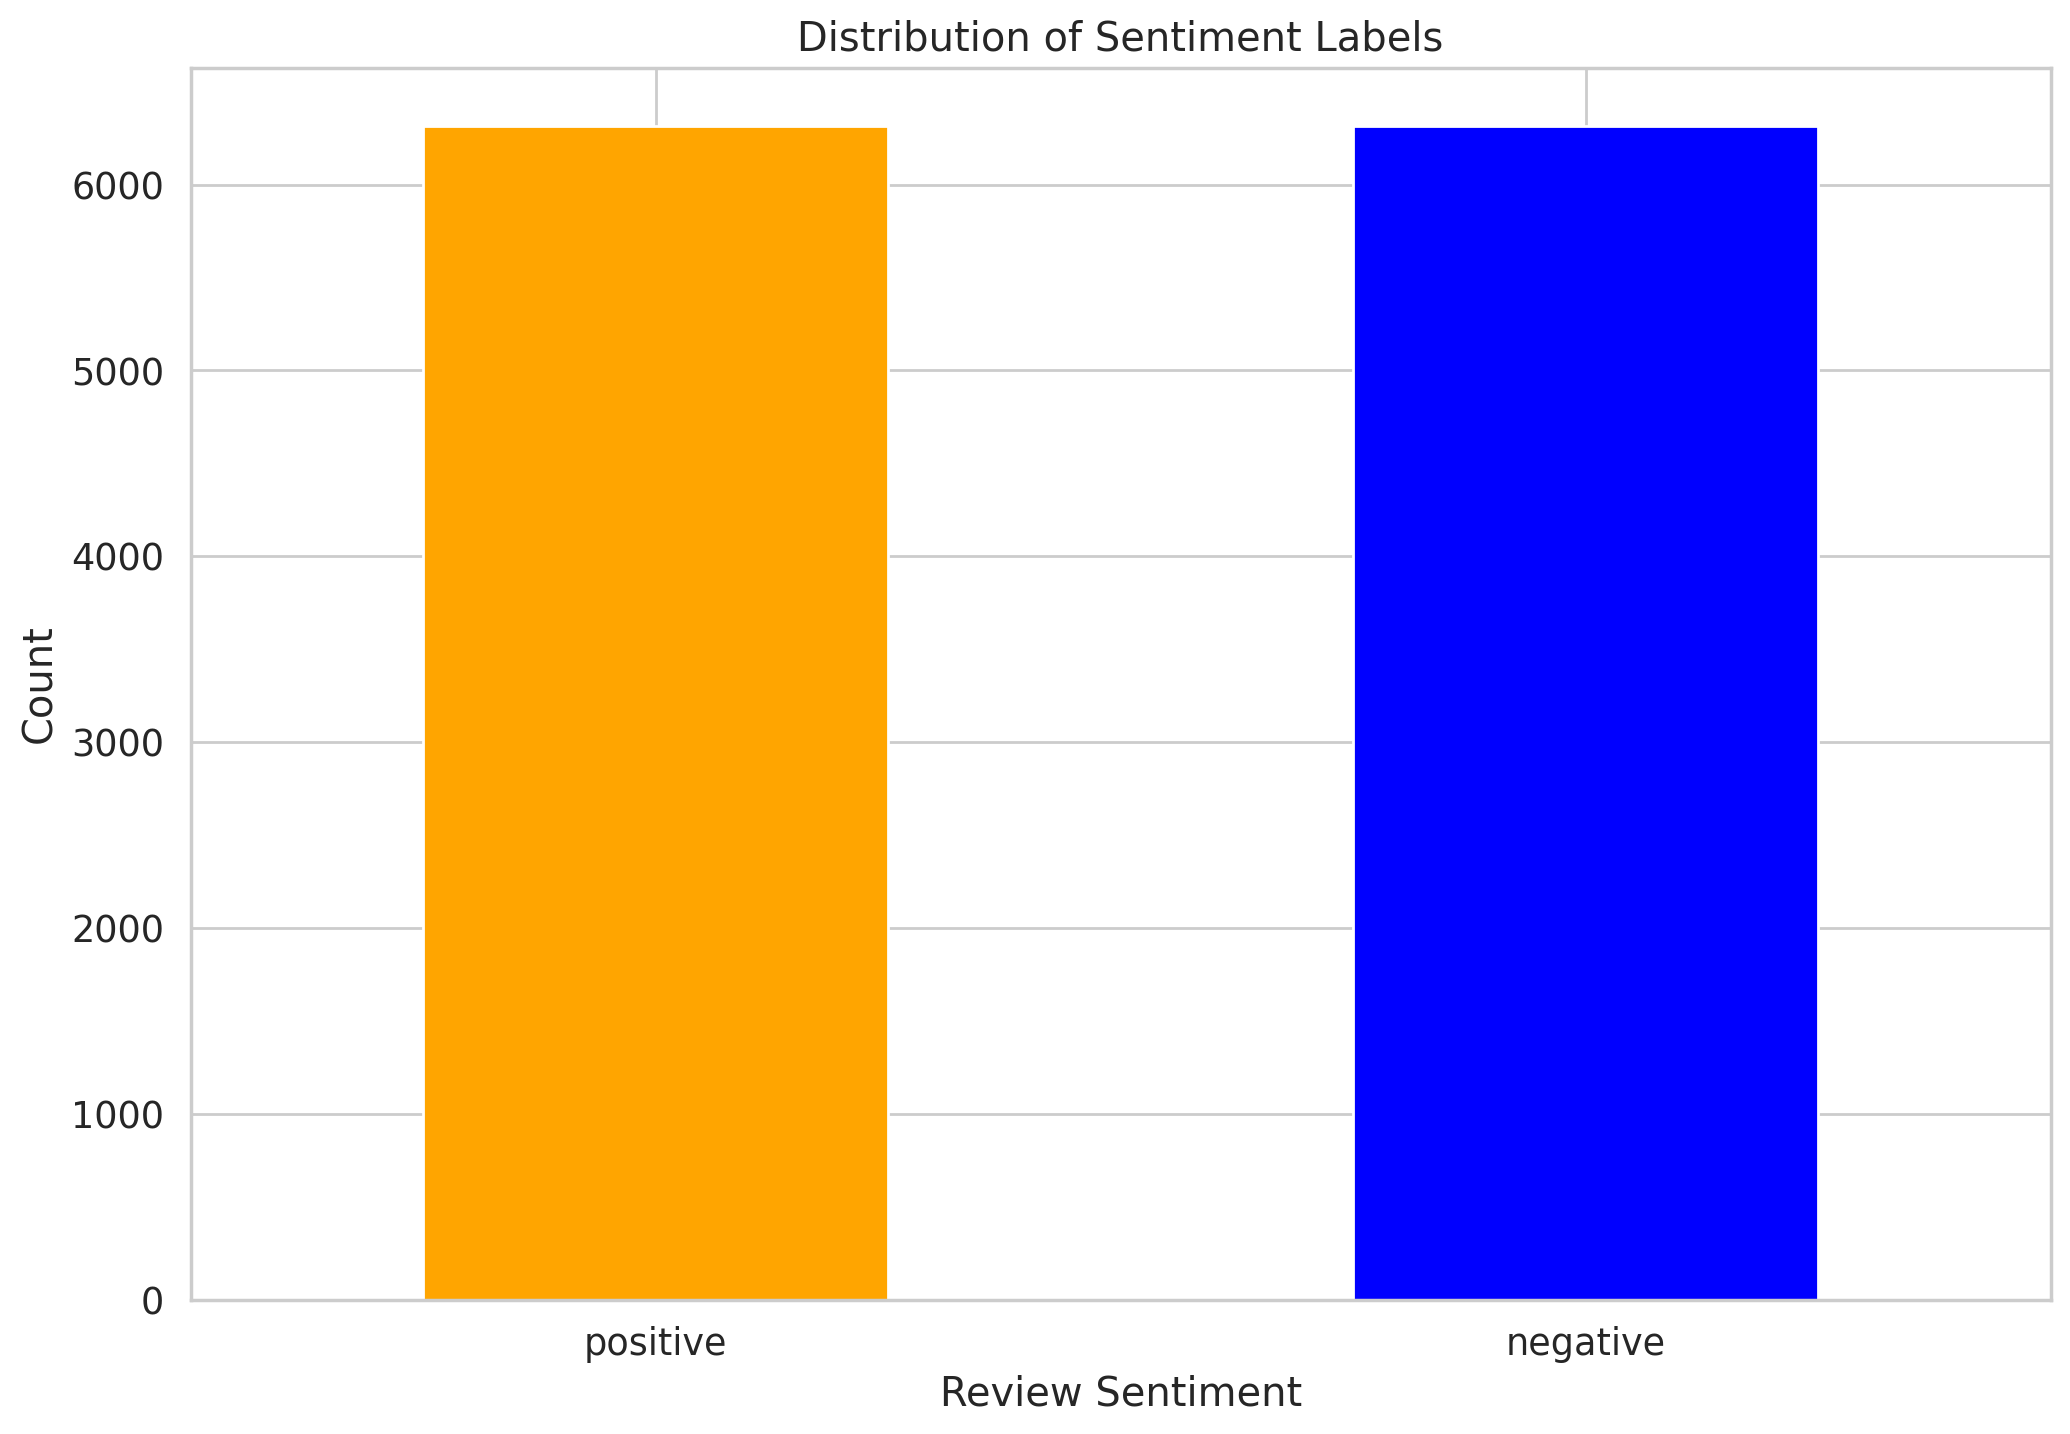

In [23]:
# Plotting the distribution using value_counts and bar plot
df_balanced['Sentiment'].value_counts().plot(kind='bar', color=['orange', 'blue'])
plt.xticks([0, 1], ['positive', 'negative'], rotation=0)  # Label the x-ticks
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Labels')
plt.show()

In [24]:
# Save df_balanced as a CSV file
df_balanced.to_csv('df_balanced.csv', index=False)
